In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from transforms import *
from FISTA_RMS import *
from rm_clean import *
from matplotlib import rc
from performance import *
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [2]:
#Constants and scales for lambda2 and phi
c = 2.99792458e8
m = 126 #Number of channels
w_min = 3.6 #wavelength start cm
w_max = 50.0 #wavelength end cm

w2_min = (w_min/100.0)*(w_min/100.0) #Min lambda2 in m^2
w2_max = (w_max/100.0)*(w_max/100.0) #Max lambda2 in m^2

lambda2_ref = (w2_max+w2_min)/2 #Reference lambda2 -> lambda2_0
delta_lambda2 = (w2_max-w2_min)/(m-1) #delta lambda2

lambda2 = np.arange(w2_min, w2_max, delta_lambda2) #lambda2 sampling

delta_phi = 2*np.sqrt(3)/(w2_max-w2_min) # delta phi as Brentjens et al - FWHM of the main peak of the RMSF

phi_max = np.sqrt(3)/delta_lambda2 #Phi max as Brentjens et al

times = 4

phi_r = delta_phi/times #The resolution is 4 times less than the FWHM of the main peak of the RMSF

temp = np.int(np.floor(2*phi_max/phi_r)) #we calculate the number of grid points N
n = temp-np.mod(temp,32) #We make sure that n is a even number to use the wavelet transform

phi_r = 2*phi_max/n; 
phi = phi_r*np.arange(-(n/2),(n/2), 1) #phi sampling

In [3]:
#Constructing simulated thick sources
#2 complex thick sources
sources_F = [2-1j*2, -6+1j*3] #Jy
#Positions in phi
pos_F = [[-120,-40], [30, 70]]

F = np.zeros(n) + 1j*np.zeros(n) # We create our Faraday dispersion function
W = np.ones(m) # We assume that our observation windows has uniform weights for the m channels
K = 1/np.sum(W); #Normalising constant

#We create our thick sources in F
for i in range(0,len(sources_F)):
    ps_idx_1 = (np.abs(phi-pos_F[i][0])).argmin()
    ps_idx_2 = (np.abs(phi-pos_F[i][1])).argmin()
    F[ps_idx_1:ps_idx_2] = sources_F[i]

In [4]:
#We go to lambda2 space - This is not used, is only to plot it if you want
P = form_P(F, phi, lambda2, 0, m)
#We get the RMSF
R = form_R(K, W, phi, lambda2, lambda2_ref, n)
#We get the complex polarized emission
P_meas = form_P_meas(W, F, phi, lambda2, 0, m)
#We get the dirty Faraday dispersion function
F_dirty = form_F_dirty(K, P_meas, phi, lambda2, 0, n)

In [17]:
#We define our FISTA arguments
soft_thresholds = [0.1, 8.0, 1.0]

In [18]:
#We reconstruct our Faraday dispersion function using our three FISTA Algorithms
#You can change the soft_threshold and iterations arguments if you want
F_recon_thin = Ultimate_FISTAMix(P_meas, W, K, phi, lambda2, 0, m, n, soft_thresholds[0], 1e-2, "Thin")
F_recon_thick = Ultimate_FISTAMix(P_meas, W, K, phi, lambda2, 0, m, n, soft_thresholds[1], 1e-4, "Thick")
F_recon_mix = Ultimate_FISTAMix(P_meas, W, K, phi, lambda2, 0, m, n, soft_thresholds[2], 1e-4, "Both")

In [19]:
#We define RM_CLEAN arguments
rm_clean_it = 10000
gain = 0.005
threshold = 1e-12

In [20]:
#We run RM_CLEAN
F_recon_rmclean = RM_CLEAN(P_meas, R, W, K, phi, lambda2, lambda2_ref, m, n, rm_clean_it, gain, threshold, cross_corr=True)

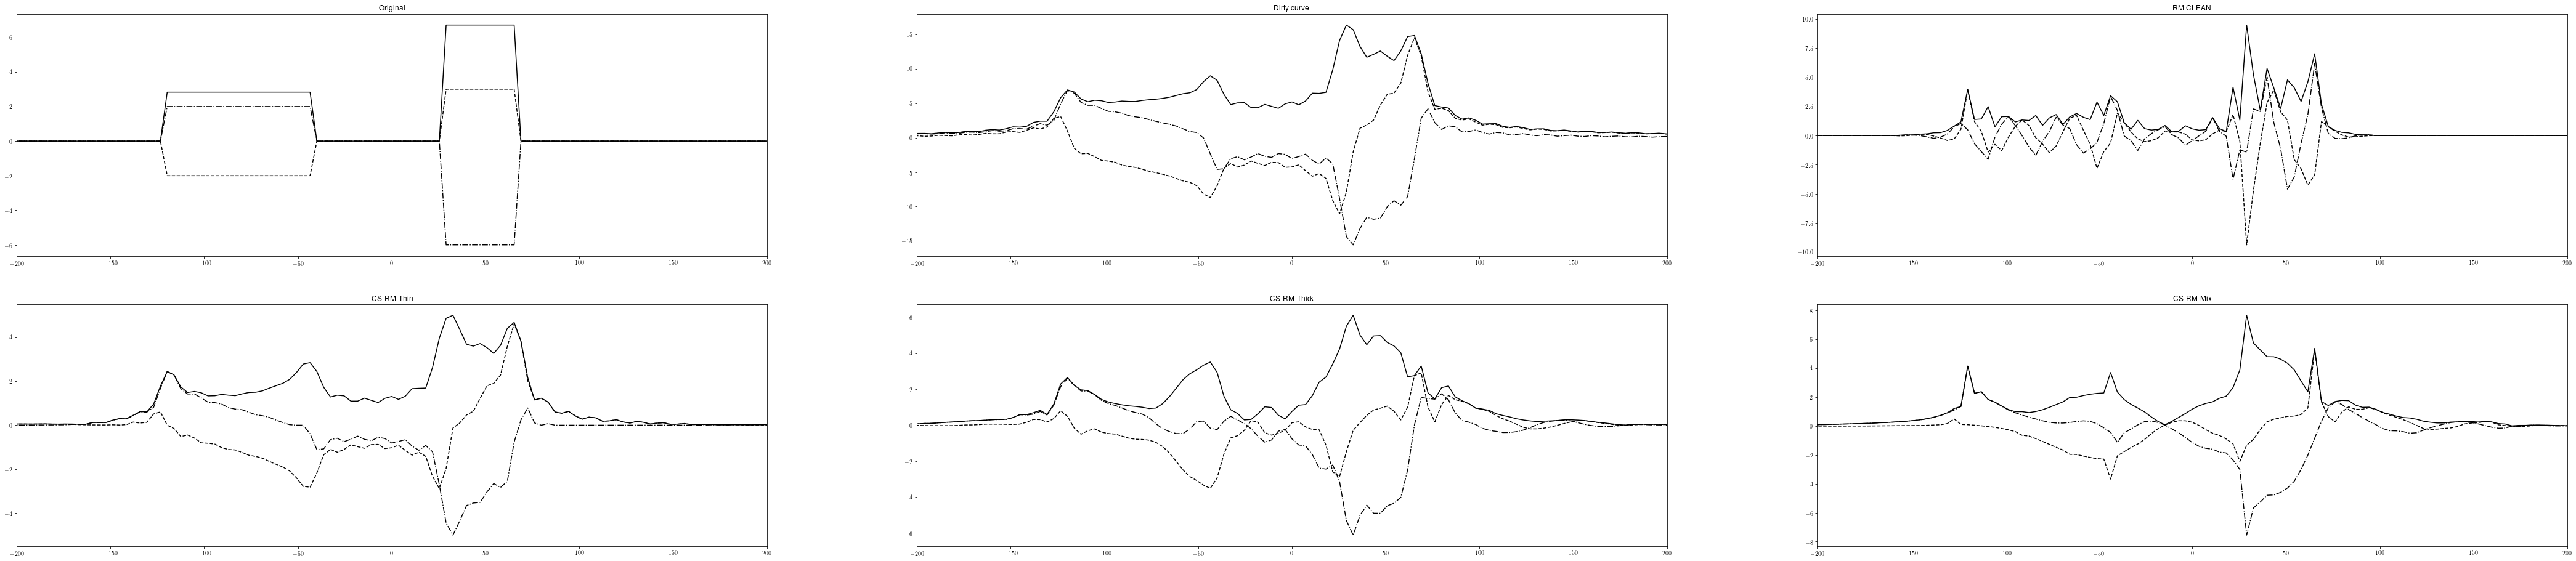

In [21]:
#We plot the results
f, axarr = plt.subplots(2, 3)

axarr[0,0].plot(phi, np.abs(F), 'k-')
axarr[0,0].plot(phi, F.real, 'k-.')
axarr[0,0].plot(phi, F.imag, 'k--')
axarr[0,0].set_ylim([None, None])
axarr[0,0].set_xlim([-200, 200])
axarr[0,0].set(title='Original')

axarr[0,1].plot(phi, np.abs(F_dirty), 'k-')
axarr[0,1].plot(phi, F_dirty.real, 'k-.')
axarr[0,1].plot(phi, F_dirty.imag, 'k--')
axarr[0,1].set_ylim([None, None])
axarr[0,1].set_xlim([-200, 200])
axarr[0,1].set(title='Dirty curve')

axarr[0,2].plot(phi, np.abs(F_recon_rmclean), 'k-')
axarr[0,2].plot(phi, F_recon_rmclean.real, 'k-.')
axarr[0,2].plot(phi, F_recon_rmclean.imag, 'k--')
axarr[0,2].set_ylim([None, None])
axarr[0,2].set_xlim([-200, 200])
axarr[0,2].set(title='RM CLEAN')

axarr[1,0].plot(phi, np.abs(F_recon_thin), 'k-')
axarr[1,0].plot(phi, F_recon_thin.real, 'k-.')
axarr[1,0].plot(phi, F_recon_thin.imag, 'k--')
axarr[1,0].set_ylim([None, None])
axarr[1,0].set_xlim([-200, 200])
axarr[1,0].set(title='CS-RM-Thin')

axarr[1,1].plot(phi, np.abs(F_recon_thick), 'k-')
axarr[1,1].plot(phi, F_recon_thick.real, 'k-.')
axarr[1,1].plot(phi, F_recon_thick.imag, 'k--')
axarr[1,1].set_ylim([None, None])
axarr[1,1].set_xlim([-200, 200])
axarr[1,1].set(title='CS-RM-Thick')


axarr[1,2].plot(phi, np.abs(F_recon_mix), 'k-')
axarr[1,2].plot(phi, F_recon_mix.real, 'k-.')
axarr[1,2].plot(phi, F_recon_mix.imag, 'k--')
axarr[1,2].set_ylim([None, None])
axarr[1,2].set_xlim([-200, 200])
axarr[1,2].set(title='CS-RM-Mix')

plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.subplots_adjust(bottom=0.5)

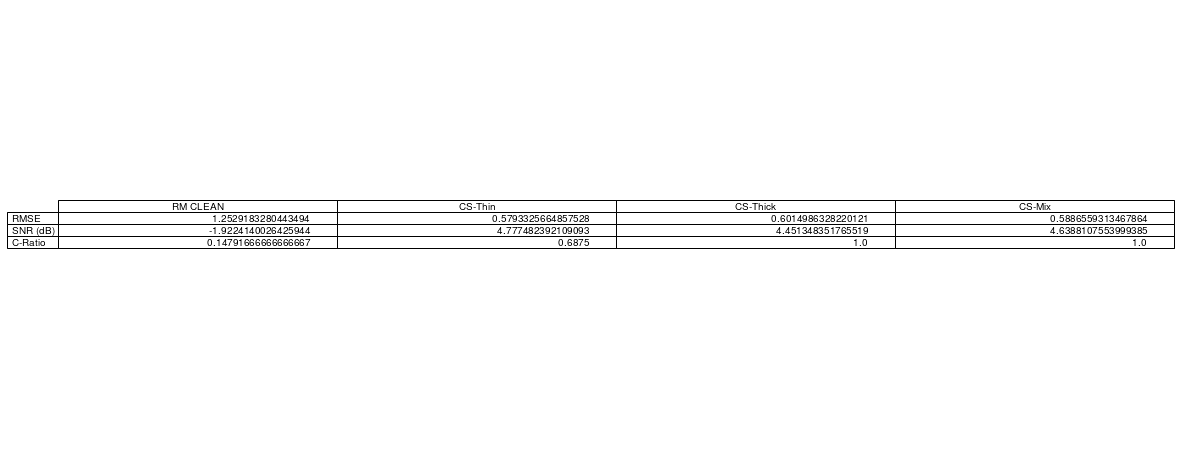

In [22]:
# Tables and plots for Real parts
fig, axs = plt.subplots(1,1)
plt.rcParams["figure.figsize"] = 20,8
collabel=("RM CLEAN", "CS-Thin", "CS-Thick", "CS-Mix")
rows = ("RMSE", "SNR (dB)", "C-Ratio")
data = np.zeros((3,4))

F_orig = F.real
F_rm_clean = F_recon_rmclean.real
F_thin = F_recon_thin.real
F_thick = F_recon_thick.real
F_mix = F_recon_mix.real

# RMSE

data[0,0] = RMSE(F_orig, F_rm_clean)
data[0,1] = RMSE(F_orig, F_thin)
data[0,2] = RMSE(F_orig, F_thick)
data[0,3] = RMSE(F_orig, F_mix)

# SNR

data[1,0] = SNR(F_orig, F_rm_clean)
data[1,1] = SNR(F_orig, F_thin)
data[1,2] = SNR(F_orig, F_thick)
data[1,3] = SNR(F_orig, F_mix)

# Compressibility Ratio

data[2,0] = CompressibilityRatio(F_rm_clean)
data[2,1] = CompressibilityRatio(F_thin)
data[2,2] = CompressibilityRatio(F_thick)
data[2,3] = CompressibilityRatio(F_mix)

axs.axis('tight')
axs.axis('off')

the_table = axs.table(cellText=data, rowLabels=rows, colLabels=collabel,loc='center')

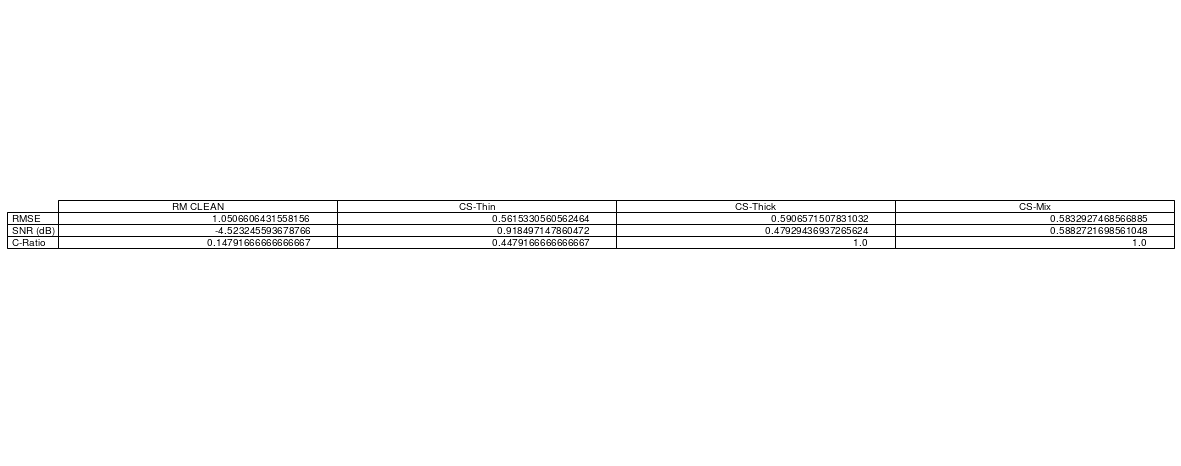

In [23]:
# Tables and plots for Imaginary parts
fig, axs = plt.subplots(1,1)
plt.rcParams["figure.figsize"] = 22,8
collabel=("RM CLEAN", "CS-Thin", "CS-Thick", "CS-Mix")
rows = ("RMSE", "SNR (dB)", "C-Ratio")
data = np.zeros((3,4))

F_orig = F.imag
F_rm_clean = F_recon_rmclean.imag
F_thin = F_recon_thin.imag
F_thick = F_recon_thick.imag
F_mix = F_recon_mix.imag

# RMSE

data[0,0] = RMSE(F_orig, F_rm_clean)
data[0,1] = RMSE(F_orig, F_thin)
data[0,2] = RMSE(F_orig, F_thick)
data[0,3] = RMSE(F_orig, F_mix)

# SNR

data[1,0] = SNR(F_orig, F_rm_clean)
data[1,1] = SNR(F_orig, F_thin)
data[1,2] = SNR(F_orig, F_thick)
data[1,3] = SNR(F_orig, F_mix)

# Compressibility Ratio

data[2,0] = CompressibilityRatio(F_rm_clean)
data[2,1] = CompressibilityRatio(F_thin)
data[2,2] = CompressibilityRatio(F_thick)
data[2,3] = CompressibilityRatio(F_mix)

axs.axis('tight')
axs.axis('off')

the_table = axs.table(cellText=data, rowLabels=rows, colLabels=collabel,loc='center')